# Overview of the Oral Cancer Prediction Project

This project aims to develop a machine learning model to predict oral cancer diagnosis based on various risk factors, symptoms, and demographic information. The dataset contains 84,922 rows and 25 columns, including features like age, gender, tobacco use, alcohol consumption, HPV infection, and various oral symptoms.

In [140]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Here, I load in the full dataset and print out a summary of the columns and data types. Most of the columns are binary Yes/No features. There are no missing values in over 80K rows, which is sufficient data for this classification task.

In [90]:
df = pd.read_csv("/kaggle/input/oral-cancer-prediction-dataset/oral_cancer_prediction_dataset.csv")
df = df.drop_duplicates()
df = df.set_index('ID')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84922 entries, 1 to 84922
Data columns (total 24 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Country                                   84922 non-null  object 
 1   Age                                       84922 non-null  int64  
 2   Gender                                    84922 non-null  object 
 3   Tobacco Use                               84922 non-null  object 
 4   Alcohol Consumption                       84922 non-null  object 
 5   HPV Infection                             84922 non-null  object 
 6   Betel Quid Use                            84922 non-null  object 
 7   Chronic Sun Exposure                      84922 non-null  object 
 8   Poor Oral Hygiene                         84922 non-null  object 
 9   Diet (Fruits & Vegetables Intake)         84922 non-null  object 
 10  Family History of Cancer               

In [91]:
df.index.names

FrozenList(['ID'])



There are many features in the dataset that are not suitable for making diagnosis predictions. Features like Cancer Stage and Treatment Type effectively tell us that the patient has cancer, so they should not be used to infer a patient's diagnosis. To prevent data leakage, Cancer Stage, Treatment Type, Survival Rate, Cost of Treatment, Economic Burden, Tumor Size, and Early Diagnosis are discarded. These may possible be used in further applications or validation efforts later on.

In [92]:
df = df.drop(labels=['Cancer Stage', 'Treatment Type', 'Survival Rate (5-Year, %)',
                     'Cost of Treatment (USD)', 'Economic Burden (Lost Workdays per Year)', 
                     'Tumor Size (cm)', 'Early Diagnosis'], axis=1)


Now, the dataset only contains features that can be used for diagnosis like lifestyle, demographic, and risk factors as well as medical history and symptoms. The following EDA will help determine which high-information features to use and which to discard due to co-linearity or overall low-information gain.

In [93]:
df.info()

for col in df.columns:
        print(f'\n{col}\n{df[col].unique()}\n')

<class 'pandas.core.frame.DataFrame'>
Index: 84922 entries, 1 to 84922
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Country                            84922 non-null  object
 1   Age                                84922 non-null  int64 
 2   Gender                             84922 non-null  object
 3   Tobacco Use                        84922 non-null  object
 4   Alcohol Consumption                84922 non-null  object
 5   HPV Infection                      84922 non-null  object
 6   Betel Quid Use                     84922 non-null  object
 7   Chronic Sun Exposure               84922 non-null  object
 8   Poor Oral Hygiene                  84922 non-null  object
 9   Diet (Fruits & Vegetables Intake)  84922 non-null  object
 10  Family History of Cancer           84922 non-null  object
 11  Compromised Immune System          84922 non-null  object
 12  Oral Lesi

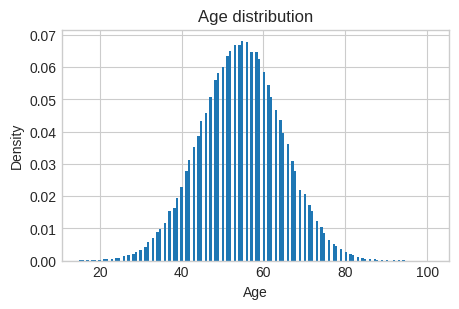

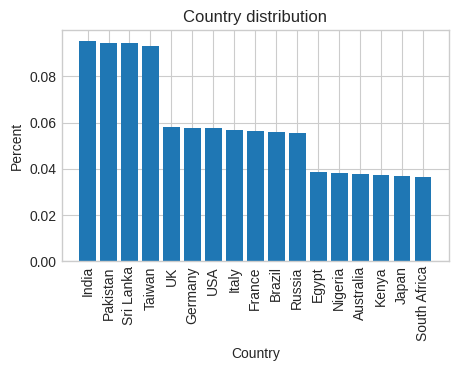

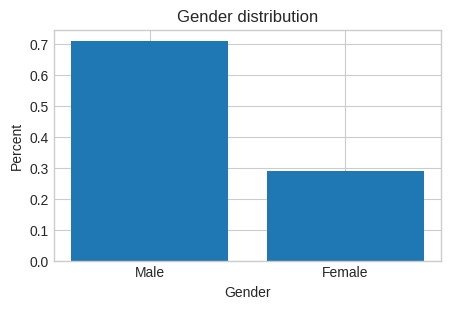

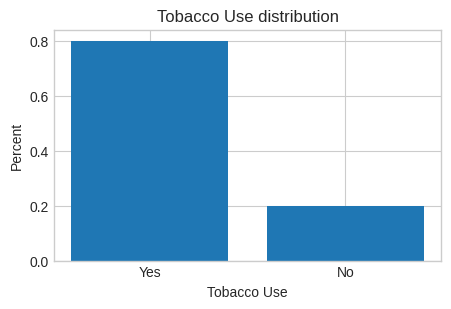

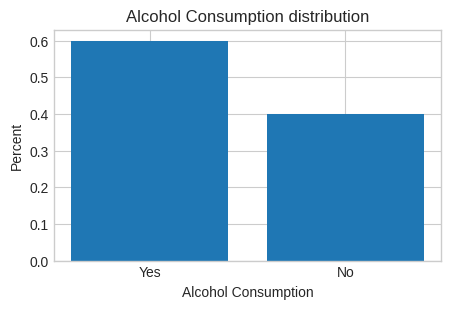

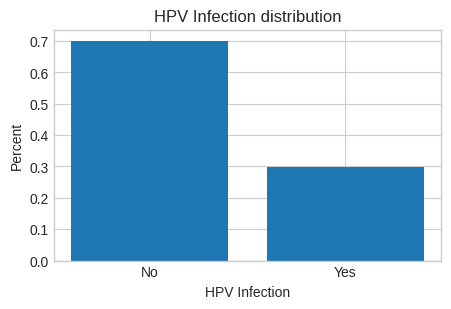

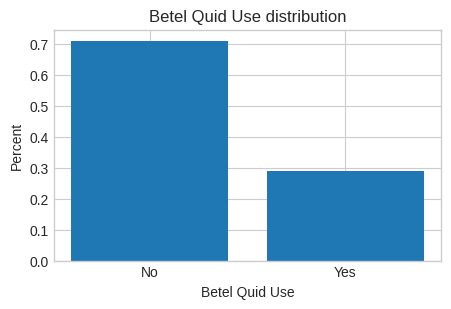

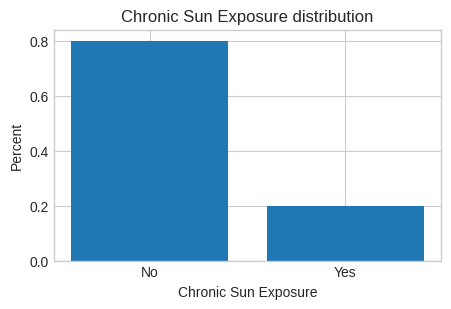

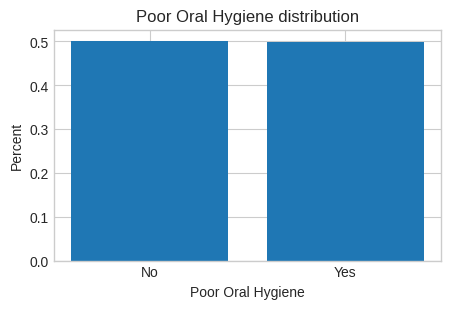

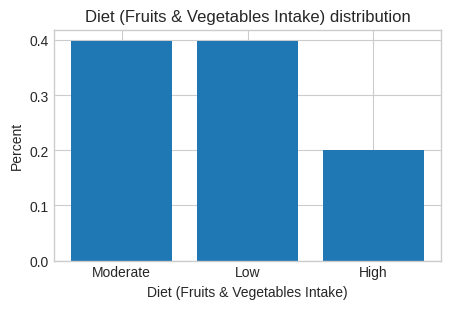

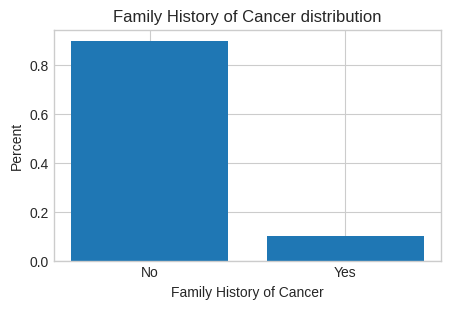

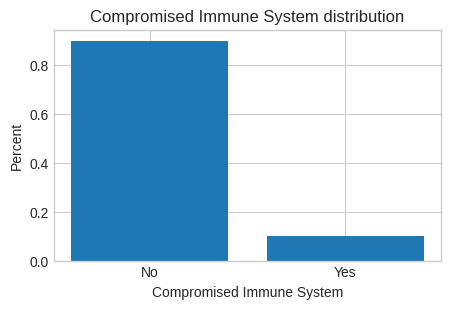

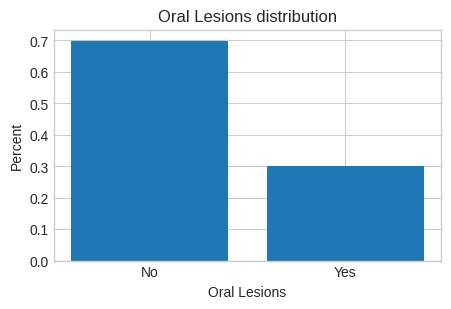

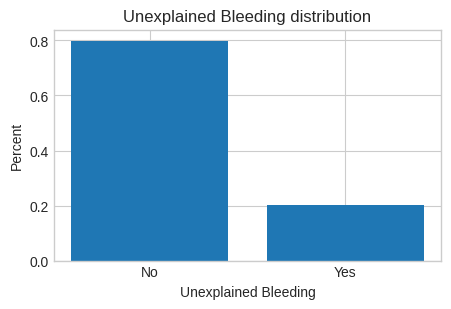

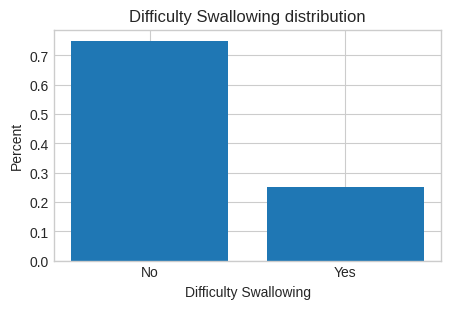

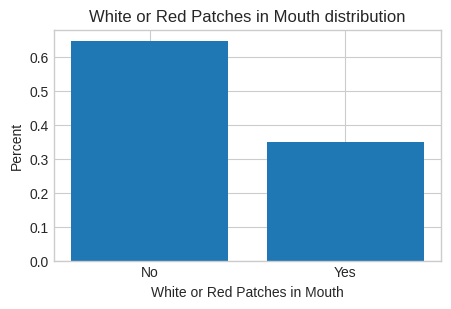

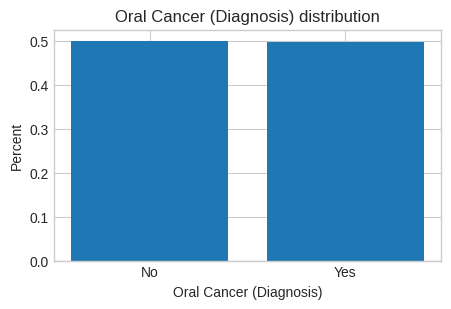

In [130]:
def eda_plots(df):

    df = df.copy()
    numeric_cols = df.select_dtypes(include='number').columns
    categorical_cols = df.select_dtypes(exclude='number').columns

    for col in numeric_cols:
        fig, ax = plt.subplots(figsize=(5, 3))
        ax.hist(df[col], bins='auto', density='True')
        ax.set_xlabel(col)
        ax.set_ylabel('Density')
        ax.set_title(f'{col} distribution')

    for col in categorical_cols:
        value_counts = df[col].value_counts()
        fig, ax = plt.subplots(figsize=(5, 3))
        ax.bar(x=value_counts.index, height=value_counts.values/len(df))
        if col == 'Country':
            ax.tick_params(axis='x', rotation=90)
        ax.set_xlabel(col)
        ax.set_ylabel('Percent')
        ax.set_title(f'{col} distribution')
        
    return None

eda_plots(df)

Just looking at the distribution of the features, it seems that the target shows a near-perfect split between positive and negative oral cancer diagnoses, but many of the symptoms and other risk factors show lofty imabalances. As some have commented, this is atypical for medical data, especially for cancer diagnosis. Typically, oral cancer has a prevalence of around 3% in high risk settings.

The feature imbalances are more realistic than the distribution of the target variable, but may pose classification challenges, but can possibly be mitigated through up-sampling or weighting. It is expected that the majority of people do not have symptoms like oral sores or difficulty swallowing. Despite being more realistic, HPV, tobacco use, and alcohol consumption prevalence do not seem to match global prevalence for the age group (based on some cursory googling). Getting more insight into the data integrity would be great, but as this is an exercise in supervised learning, it is not my most pressing concern (though, I would like some answers).

The patient age distribution is normally distributed and centered around 56 years of age. Because most of the patients are older than middle aged, the information from this model may not generalize well for younger patients, limiting its field applications. It also limits our insights as risk factors may be age-related.

Most of the data is from patients in eastern countries like India, Pakistan, and Taiwan. African countries are represented the least in the data set, and western countries fall inbetween.

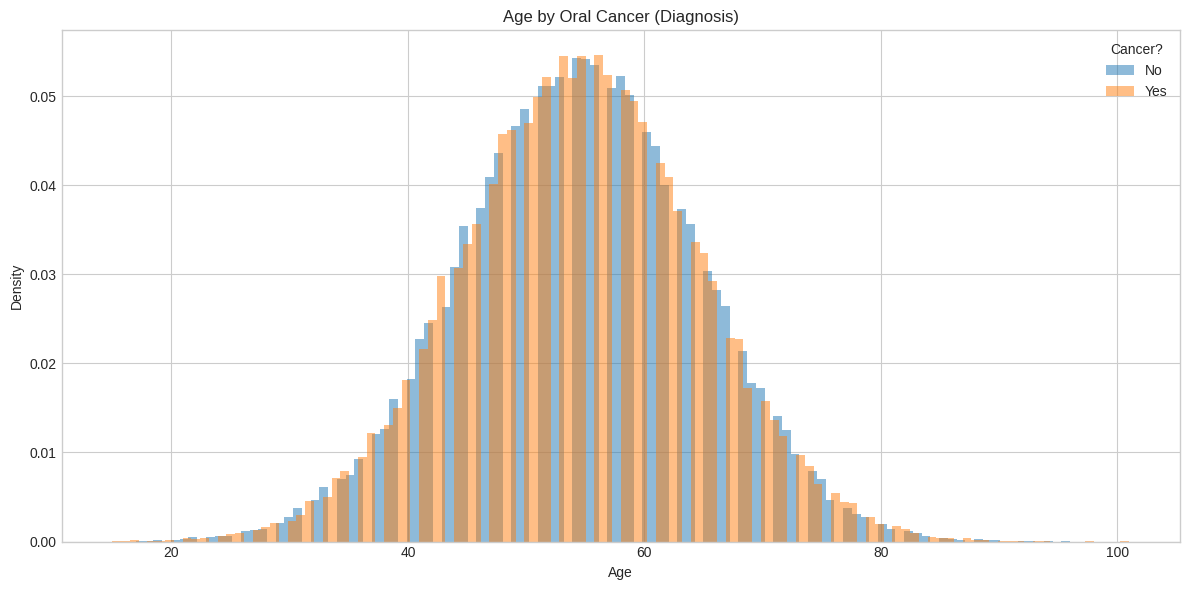

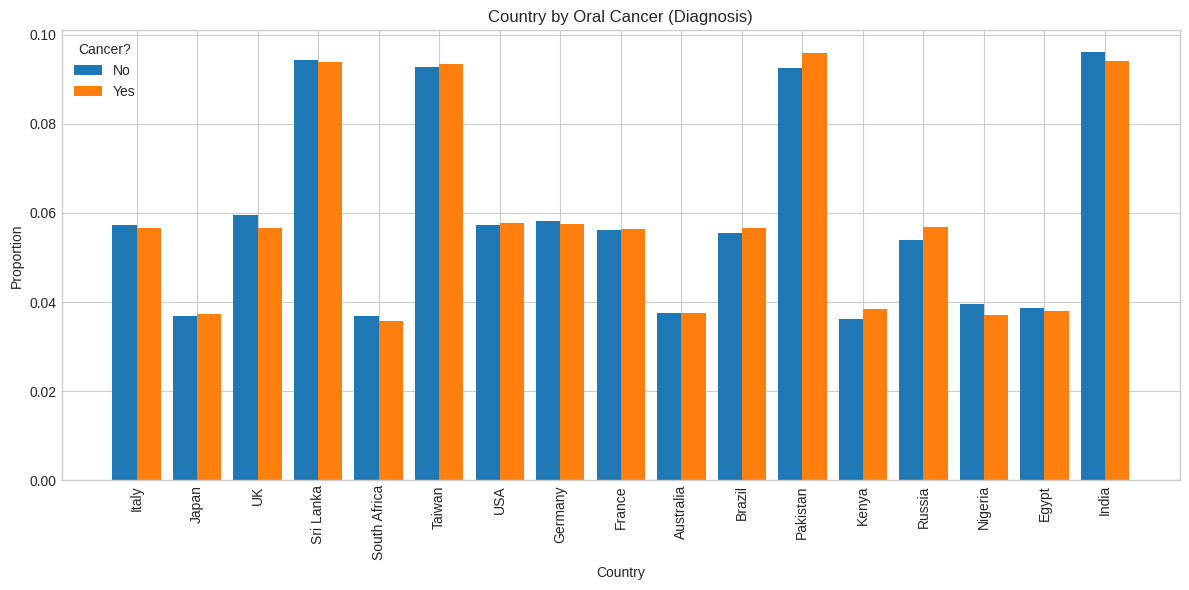

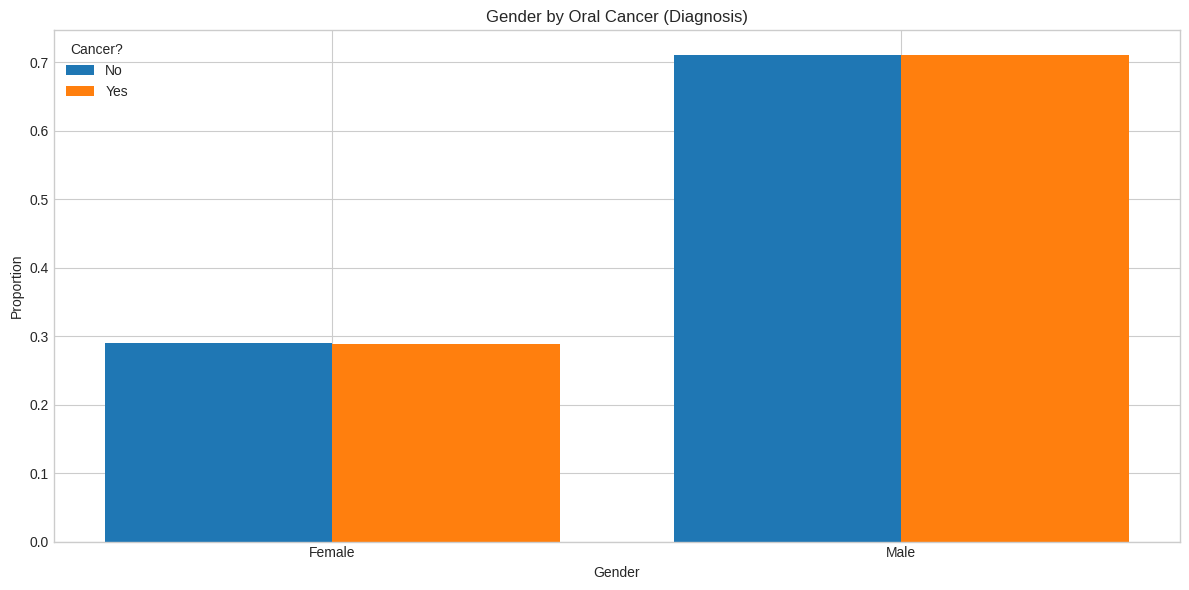

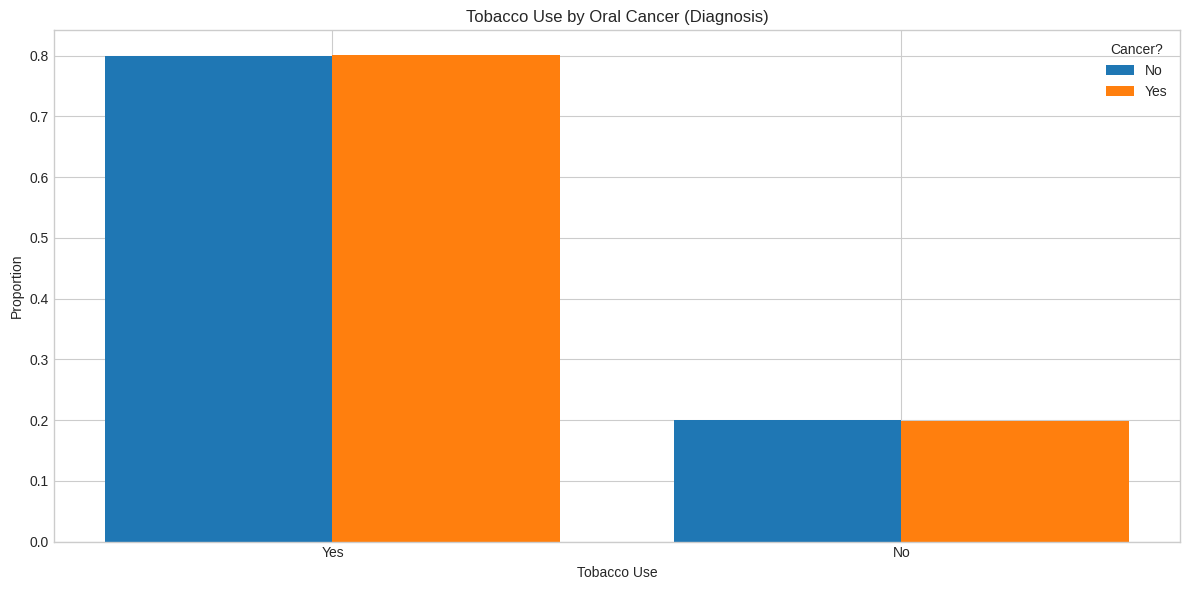

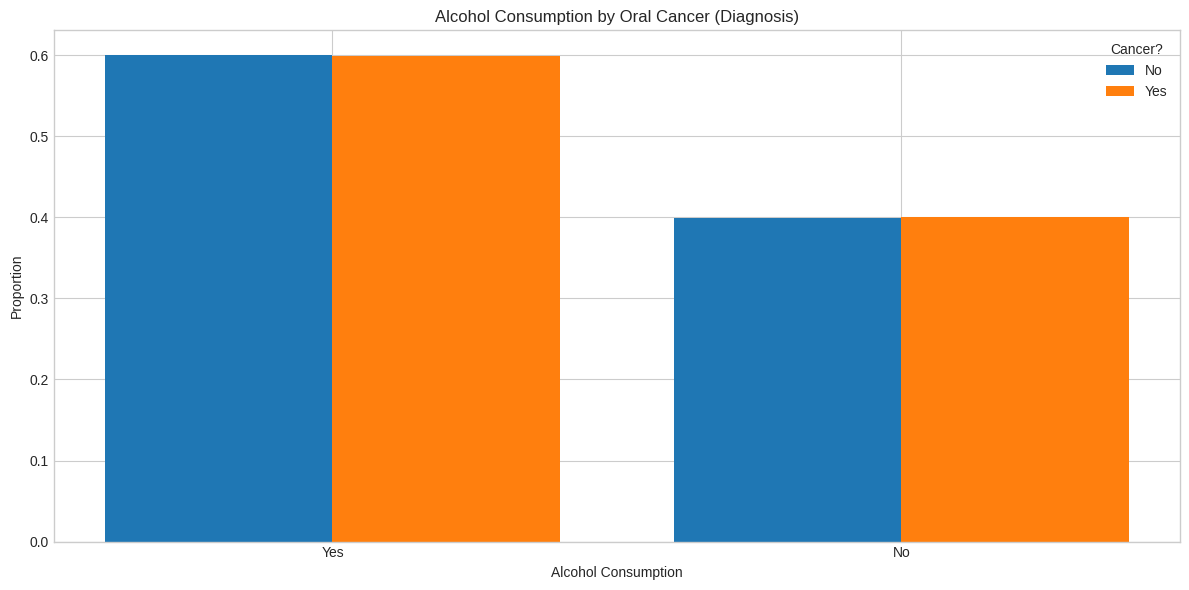

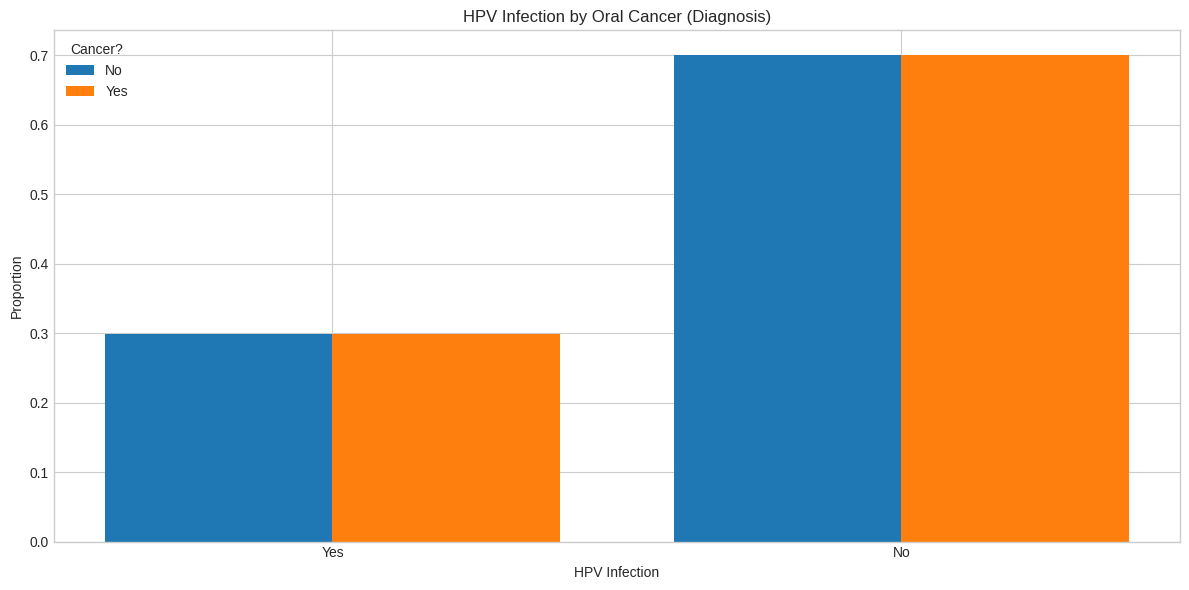

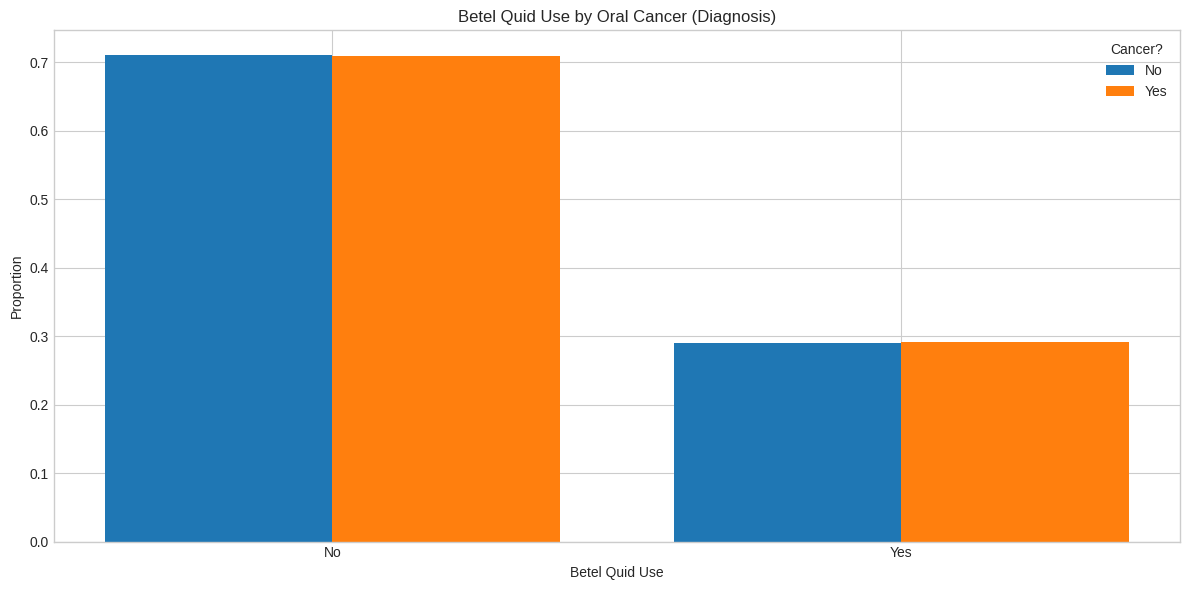

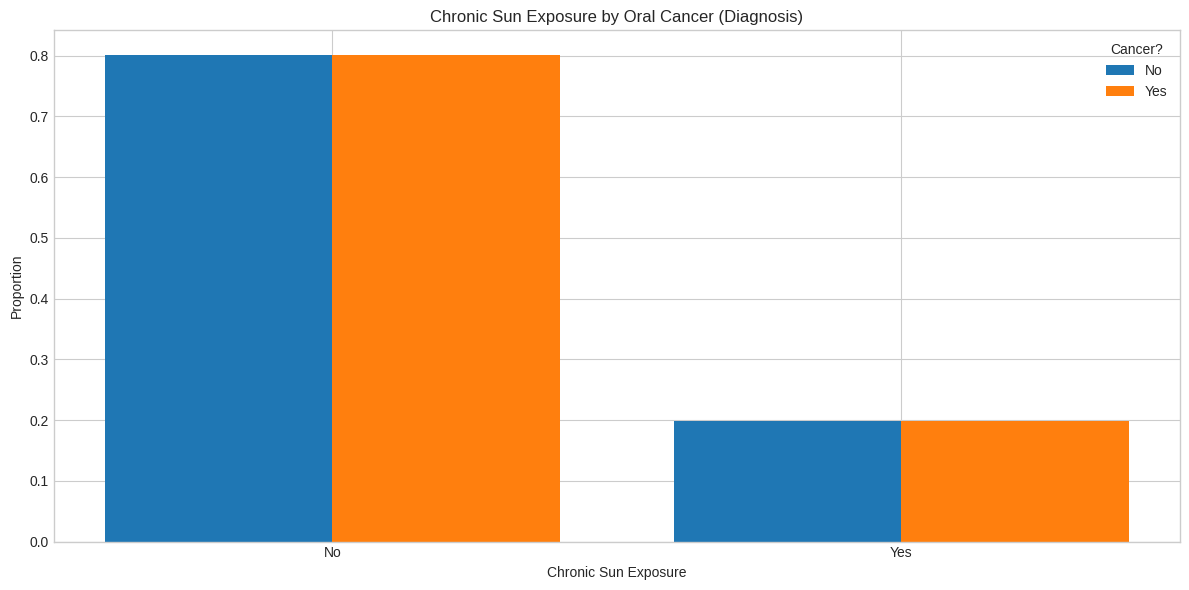

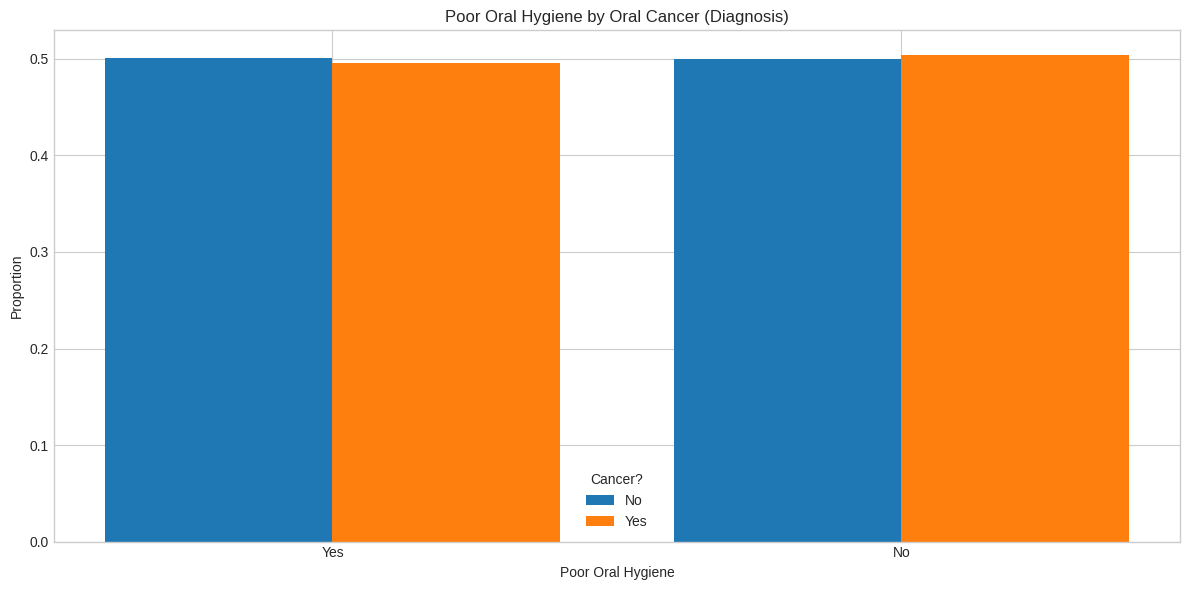

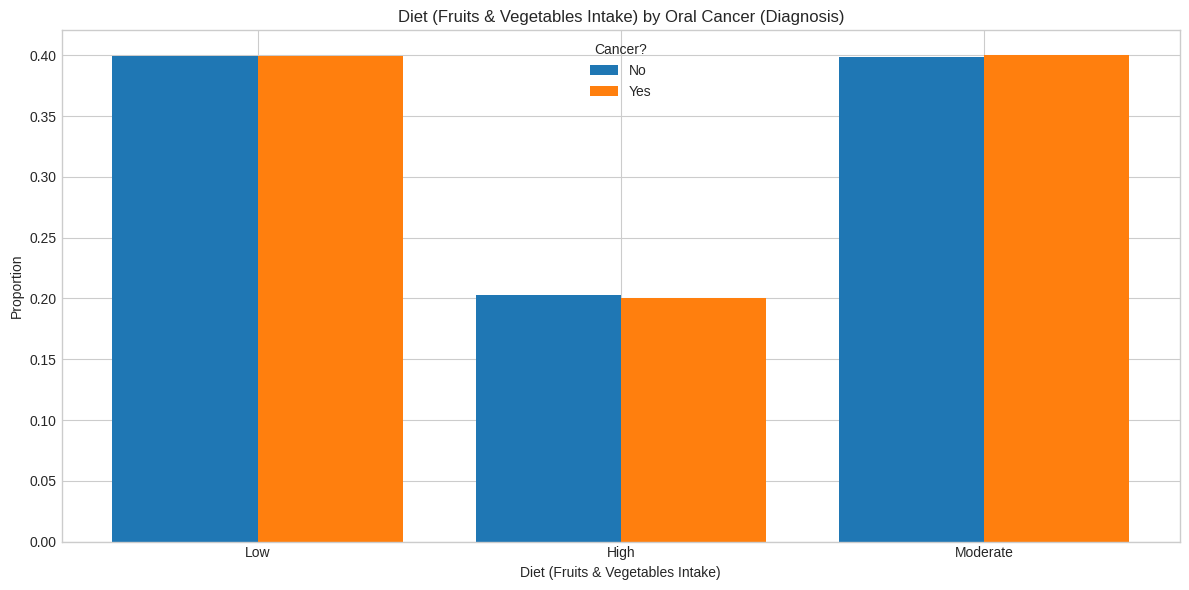

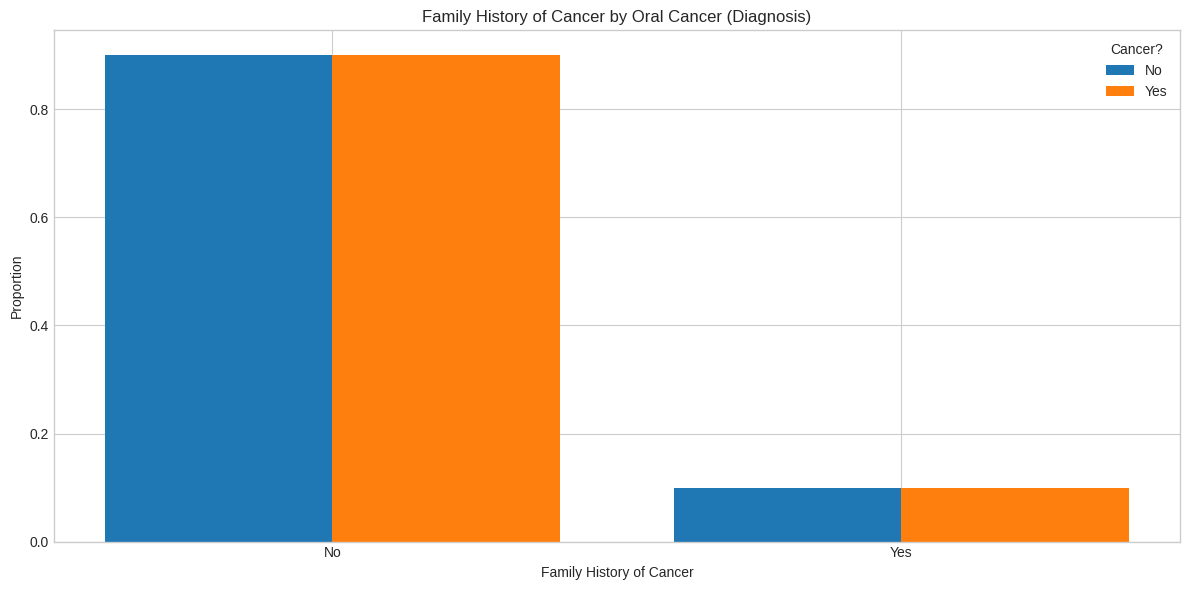

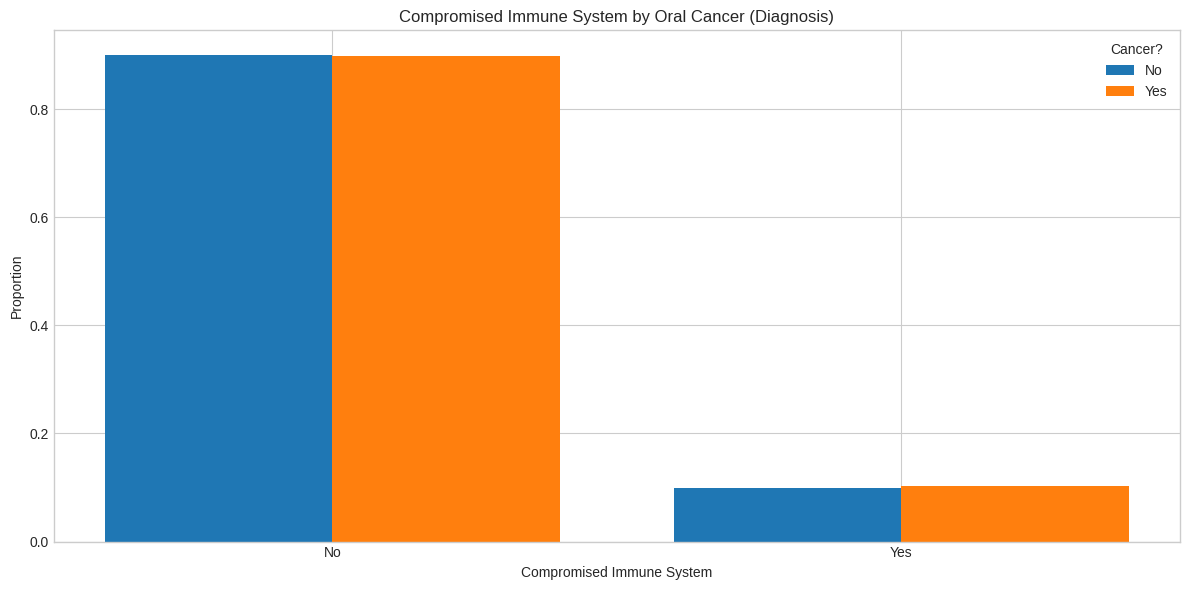

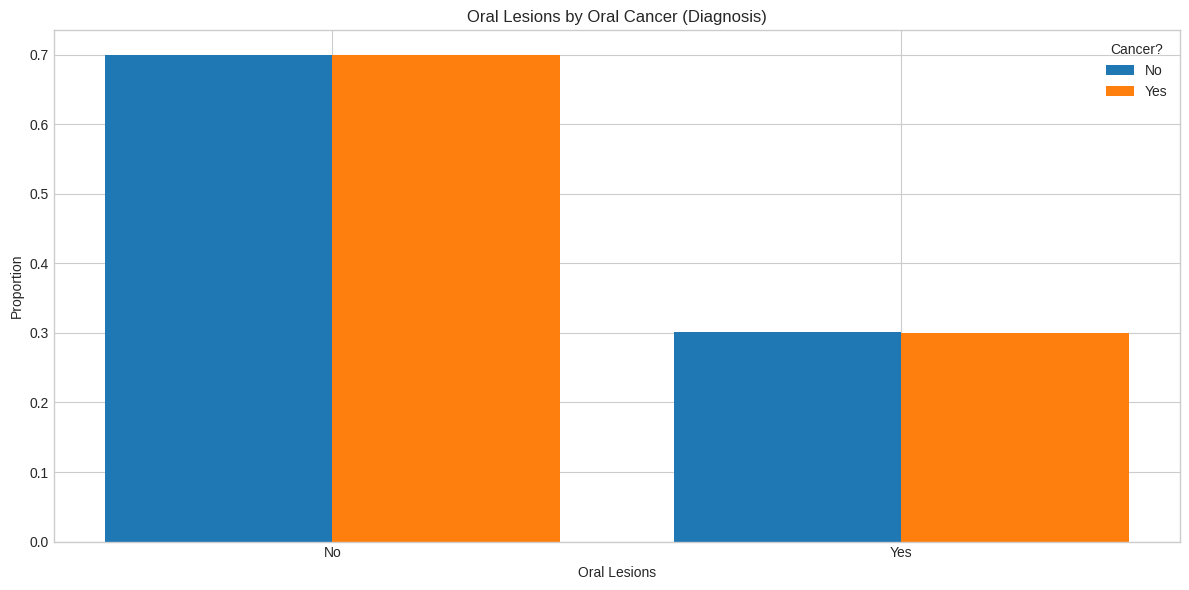

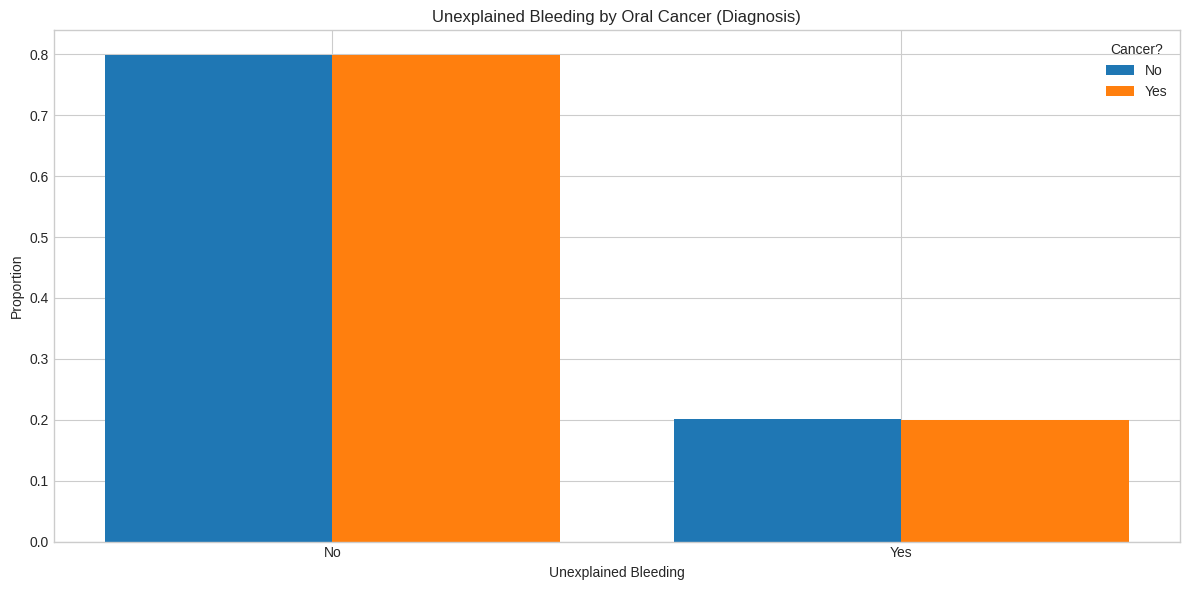

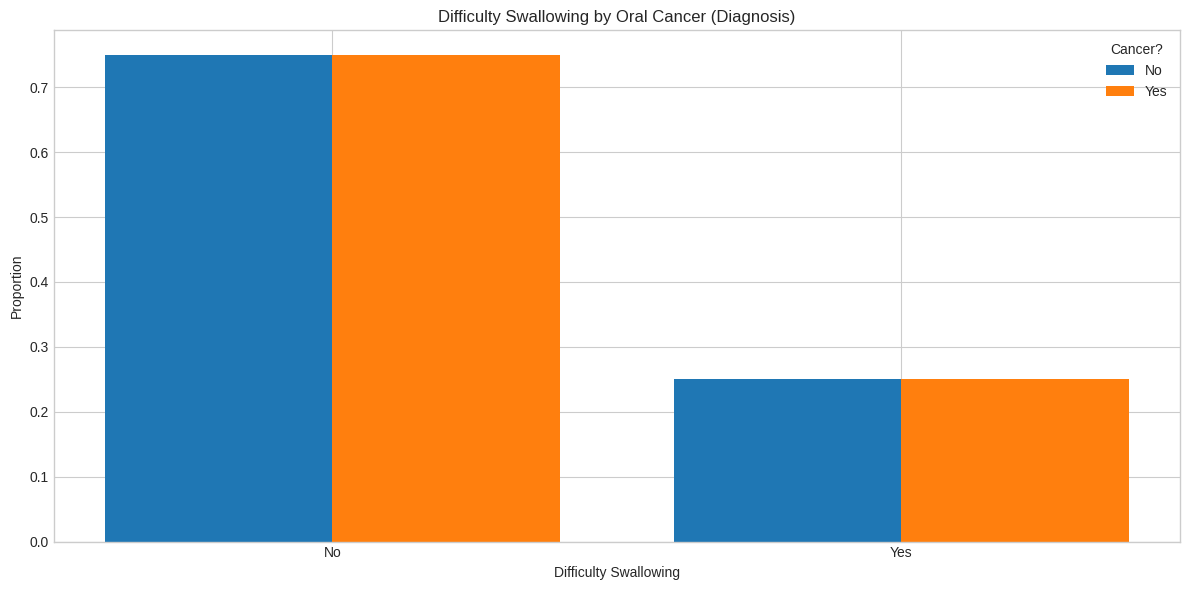

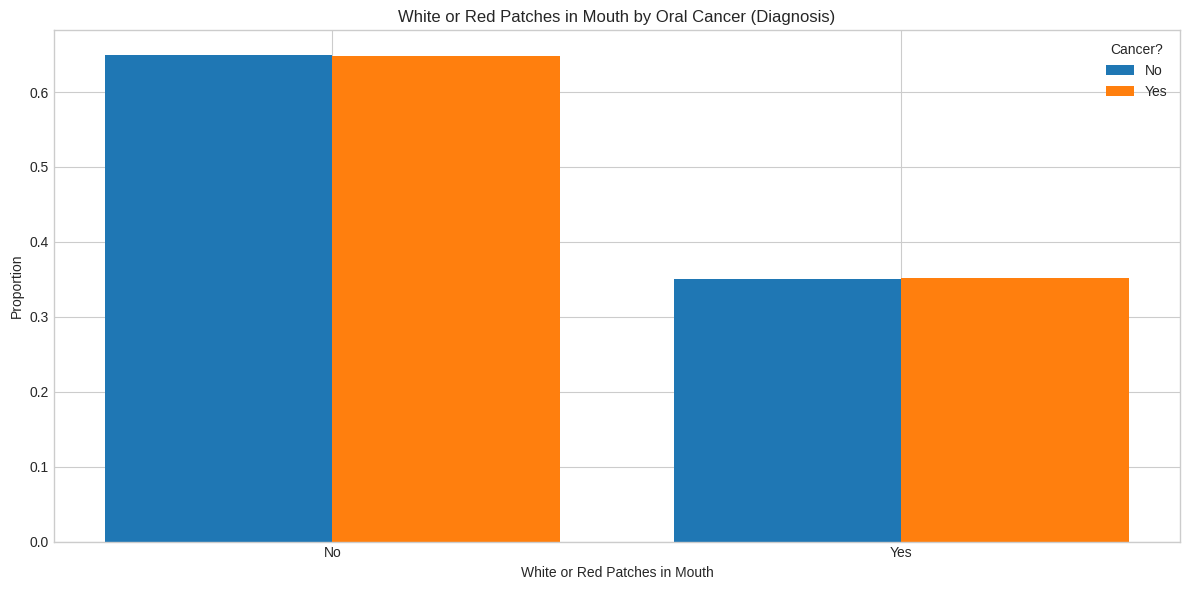

In [146]:
def eda_plots_by_diagnosis(df, target_col):

    df = df.copy()

    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
    
    categorical_cols = df.select_dtypes(exclude='number').columns.tolist()
    if target_col in categorical_cols:
        categorical_cols.remove(target_col)
    

    target_values = df[target_col].unique()
    
    for col in numeric_cols:
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for target_value in target_values:
            subset = df[df[target_col] == target_value]
            ax.hist(subset[col], bins='auto', density='True', alpha=0.5, label=f'{target_value}')
        
        ax.set_xlabel(col)
        ax.set_ylabel('Density')
        ax.set_title(f'{col} by {target_col}')
        ax.legend(title='Cancer?')
        plt.tight_layout()
        plt.show()
    
    for col in categorical_cols:
        fig, ax = plt.subplots(figsize=(12, 6))
        categories = df[col].unique()
        x = np.arange(len(categories))
        w = 0.4
        
        for i, target_value in enumerate(target_values):
            subset = df[df[target_col] == target_value]
            counts = pd.Series(0, index=categories)
            counts.update(subset[col].value_counts())

            
            ax.bar(x + (i-0.5)*w, counts.values/len(subset), w, label=f'{target_value}')

            ax.set_title(f'{col} by {target_col}')
            ax.set_xlabel(col)
            ax.set_xticks(x)
            ax.set_ylabel('Proportion')
            ax.set_xticklabels(categories)
            ax.legend(title='Cancer?')
            
            if col == 'Country':
                ax.tick_params(axis='x', rotation=90)
        
        plt.tight_layout()
        plt.show()
    
    return None

eda_plots_by_diagnosis(df, target_col='Oral Cancer (Diagnosis)' )

Additional EDA shows that when grouping features by diagnosis, every feature shows a near 50/50 split despite cancer diagnosis. It is now knownthat the data is likely artificial (although not sufficiently disclosed) and lacks real world prevalance rates for these features. What this means for modeling is that these features likely do not have much predictive power. It is unlikely that, of the people with red patches in their mouth, 50% have cancer. Just as it is unlikely that 50% of people have cancer overall. It is likely that fearure importance will not align with real global correlations.

## 3. Exploratory Data Analysis

## 4. Data Preprocessing

## 5. Feature Selecton

## 6. Model Building

## 7. Hyperparameter Optimization

## 8. Model Evaluation

## 9. Feature Importance Analysis

## 10. Results & Discussion

## 11. Model Deployment Example